# Contrastive Analysis

In [1]:
from datasets import load_from_disk
import inseq
from inseq.data.aggregator import (
    AggregatorPipeline,
    SubwordAggregator,
    SequenceAttributionAggregator,
)
from iwslt import preprocess
import matplotlib.pyplot as plt
from rude_nmt import attribute


## Load Dataset

In [2]:
ds = load_from_disk("../data/iwslt_labelled")


In [4]:
print(ds)


Dataset({
    features: ['informal_ko', 'informal_de', 'formal_ko', 'formal_de', 'en', 'category', 'upos_tags_informal_ko', 'pos_tags_informal_ko', 'ws_tokens_informal_ko', 'sent_ids_informal_ko', 'form_map_informal_ko', 'upos_tags_informal_de', 'pos_tags_informal_de', 'ws_tokens_informal_de', 'sent_ids_informal_de', 'form_map_informal_de', 'upos_tags_formal_ko', 'pos_tags_formal_ko', 'ws_tokens_formal_ko', 'sent_ids_formal_ko', 'form_map_formal_ko', 'upos_tags_formal_de', 'pos_tags_formal_de', 'ws_tokens_formal_de', 'sent_ids_formal_de', 'form_map_formal_de'],
    num_rows: 200
})


In [29]:
model_de_ko = inseq.load_model(
    "facebook/mbart-large-50-many-to-many-mmt",
    "input_x_gradient",
    tokenizer_kwargs={"src_lang": "de_DE", "tgt_lang": "ko_KR"},
)


Loading facebook/mbart-large-50-many-to-many-mmt with input_x_gradient method...


In [30]:
model_ko_de = inseq.load_model(
    "facebook/mbart-large-50-many-to-many-mmt",
    "input_x_gradient",
    tokenizer_kwargs={"src_lang": "ko_KR", "tgt_lang": "de_DE"},
)


Loading facebook/mbart-large-50-many-to-many-mmt with input_x_gradient method...


In [6]:
def filter_sentences(
    example: dict, model: inseq.AttributionModel, formal_col: str, informal_col: str
) -> dict:
    formal = model.encode(example[formal_col], as_targets=True)
    informal = model.encode(example[informal_col], as_targets=True)

    if len(formal.input_tokens[0]) == len(informal.input_tokens[0]):
        for i in range(len(formal.input_tokens[0])):
            if formal.input_tokens[0][i] != informal.input_tokens[0][i]:
                return True

    return False


In [7]:
de_ko_matching = ds.filter(
    filter_sentences,
    fn_kwargs={
        "model": model_de_ko,
        "formal_col": "formal_ko",
        "informal_col": "informal_ko",
    },
)
print(de_ko_matching)


Loading cached processed dataset at /Users/lsickert/Repositories/rude-nmt/data/iwslt_labelled/cache-bb2499859efe1c11.arrow


Dataset({
    features: ['informal_ko', 'informal_de', 'formal_ko', 'formal_de', 'en', 'category', 'upos_tags_informal_ko', 'pos_tags_informal_ko', 'ws_tokens_informal_ko', 'sent_ids_informal_ko', 'form_map_informal_ko', 'upos_tags_informal_de', 'pos_tags_informal_de', 'ws_tokens_informal_de', 'sent_ids_informal_de', 'form_map_informal_de', 'upos_tags_formal_ko', 'pos_tags_formal_ko', 'ws_tokens_formal_ko', 'sent_ids_formal_ko', 'form_map_formal_ko', 'upos_tags_formal_de', 'pos_tags_formal_de', 'ws_tokens_formal_de', 'sent_ids_formal_de', 'form_map_formal_de'],
    num_rows: 57
})


In [8]:
ko_de_matching = ds.filter(
    filter_sentences,
    fn_kwargs={
        "model": model_ko_de,
        "formal_col": "formal_de",
        "informal_col": "informal_de",
    },
)
print(ko_de_matching)


Loading cached processed dataset at /Users/lsickert/Repositories/rude-nmt/data/iwslt_labelled/cache-b28deb952a89eb67.arrow


Dataset({
    features: ['informal_ko', 'informal_de', 'formal_ko', 'formal_de', 'en', 'category', 'upos_tags_informal_ko', 'pos_tags_informal_ko', 'ws_tokens_informal_ko', 'sent_ids_informal_ko', 'form_map_informal_ko', 'upos_tags_informal_de', 'pos_tags_informal_de', 'ws_tokens_informal_de', 'sent_ids_informal_de', 'form_map_informal_de', 'upos_tags_formal_ko', 'pos_tags_formal_ko', 'ws_tokens_formal_ko', 'sent_ids_formal_ko', 'form_map_formal_ko', 'upos_tags_formal_de', 'pos_tags_formal_de', 'ws_tokens_formal_de', 'sent_ids_formal_de', 'form_map_formal_de'],
    num_rows: 72
})


In [15]:
for example in ko_de_matching:
    print(example["formal_de"])


Die Mädchen waren hübsch und, er, die Mädchen kamen zuerst,und sagen ich kenne Sie aus Ihren Facebookbildern, als ob ich es wirklich nicht gewusst hätte, Ja, das ist es.
Haben Sie auch einen Film aus diesem Jahr oder den Sie bis jetzt gesehen haben, den Sie mögen?
Auf jeden Fall habe ich sie in die Tasche gepackt und mitgebracht. Sie sind alle neu. Lassen Sie sie einfach dort liegen.
Ja, aber das ist Ihre Interpretation des Filmes. Es gibt bestimmt auch Menschen, die sagen, dass das Unsinn ist. Mehr noch, Menschen, die glauben, dass es Aliens gibt.
Denken Sie, dass die Schule während des Erwachsenwerdens ein Teil der Familienwerte wird?
Es ist nicht Ihre Entscheidung, wo Sie geboren werden, in welche Familie Sie geboren werden möchten ist die Frage, die ich Ihnen vorhin gestellt habe
Es bedeutet, dass Sie aus irgendeinem Grund nicht genug Speicherplatz auf Ihrem Computer haben.
Ah, weiß Ihre Mutter, dass Sie diese Party veranstalten?
Was ist mit Tanten, Onkeln und Cousins? Haben Ihre E

## Perform Attributions

### Single Samples

In [9]:
# Pre-compute ids and attention map for the contrastive target
contrast = model_de_ko.encode(de_ko_matching["informal_ko"][56], as_targets=True)

out = model_de_ko.attribute(
    input_texts=de_ko_matching["formal_de"][56],
    generated_texts=de_ko_matching["formal_ko"][56],
    attributed_fn="contrast_prob_diff",
    step_scores=["contrast_prob_diff", "probability"],
    contrast_ids=contrast.input_ids,
    contrast_attention_mask=contrast.attention_mask,
)

out.weight_attributions("contrast_prob_diff")
out.show()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Attributing with input_x_gradient...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:14<00:00,  1.28s/it]
/Users/lsickert/Repositories/rude-nmt/.venv/lib/python3.10/site-packages/inseq/data/attribution.py:275: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3281.)
  step_scores = self.step_scores[step_fn_id].T.unsqueeze(1)


,ko_KR,▁제가,▁하는,▁말이,▁무슨,▁뜻,인지,▁알,죠,?,</s>
de_DE,,0.014,0.0,0.007,0.0,0.001,0.001,0.0,0.016,0.07,0.001
▁Wissen,,0.023,0.0,0.008,0.0,0.002,0.001,0.001,0.046,0.194,0.001
▁Sie,,0.01,0.0,0.004,0.0,0.001,0.0,0.0,0.02,0.103,0.0
",",,0.007,0.0,0.004,0.0,0.001,0.0,0.0,0.01,0.044,0.0
▁was,,0.01,0.0,0.004,0.0,0.001,0.0,0.0,0.009,0.06,0.0
▁ich,,0.015,0.0,0.007,0.0,0.001,0.0,0.0,0.009,0.061,0.0
▁meine,,0.024,0.0,0.018,0.0,0.004,0.001,0.001,0.018,0.096,0.001
?,,0.01,0.0,0.006,0.0,0.001,0.001,0.0,0.013,0.095,0.001
</s>,,0.009,0.0,0.005,0.0,0.001,0.0,0.0,0.01,0.051,0.0
contrast_prob_diff,0.0,0.121,0.002,0.063,0.0,0.013,0.005,0.003,0.152,0.776,0.005


In [10]:
out.show(aggregator=SubwordAggregator)


,ko_KR,▁제가,▁하는,▁말이,▁무슨,▁뜻인지,▁알죠?,</s>
de_DE,,0.014,0.0,0.007,0.0,0.001,0.07,0.001
▁Wissen,,0.023,0.0,0.008,0.0,0.002,0.194,0.001
"▁Sie,",,0.01,0.0,0.004,0.0,0.001,0.103,0.0
▁was,,0.01,0.0,0.004,0.0,0.001,0.06,0.0
▁ich,,0.015,0.0,0.007,0.0,0.001,0.061,0.0
▁meine?,,0.024,0.0,0.018,0.0,0.004,0.096,0.001
</s>,,0.009,0.0,0.005,0.0,0.001,0.051,0.0
contrast_prob_diff,0.0,0.121,0.002,0.063,0.0,0.0,0.0,0.005
probability,0.0,0.124,0.025,0.2,0.052,0.023,0.007,0.887


In [9]:
# Pre-compute ids and attention map for the contrastive target
contrast = model_ko_de.encode(ko_de_matching["informal_de"][21], as_targets=True)

out = model_ko_de.attribute(
    input_texts=ko_de_matching["formal_ko"][21],
    generated_texts=ko_de_matching["formal_de"][21],
    attributed_fn="contrast_prob_diff",
    step_scores=["contrast_prob_diff", "probability"],
    contrast_ids=contrast.input_ids,
    contrast_attention_mask=contrast.attention_mask,
)

out.weight_attributions("contrast_prob_diff")
out.show()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Attributing with input_x_gradient...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.38s/it]
/Users/lsickert/Repositories/rude-nmt/.venv/lib/python3.10/site-packages/inseq/data/attribution.py:275: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3281.)
  step_scores = self.step_scores[step_fn_id].T.unsqueeze(1)


,de_DE,▁Ist,▁das,▁Ihre,▁Lieblings,pi,zza,?,</s>
ko_KR,,,,0.001,0.002,-0.0,-0.0,0.0,-0.0
▁그,,,,0.001,0.001,-0.0,-0.0,0.0,-0.0
게,,,,0.001,0.002,-0.0,-0.0,0.0,-0.0
▁,,,,0.001,0.001,-0.0,-0.0,0.0,-0.0
님이,,,,0.007,0.013,-0.0,-0.0,0.001,-0.0
▁제일,,,,0.002,0.004,-0.0,-0.0,0.0,-0.0
▁좋아,,,,0.001,0.003,-0.0,-0.0,0.0,-0.0
하시는,,,,0.002,0.004,-0.0,-0.0,0.0,-0.0
▁피,,,,0.004,0.006,-0.0,-0.0,0.001,-0.0
자,,,,0.003,0.004,-0.0,-0.0,0.0,-0.0


In [10]:
out.show(aggregator=SubwordAggregator)


,de_DE,▁Ist,▁das,▁Ihre,▁Lieblingspizza?,</s>
ko_KR,,,,0.001,0.002,-0.0
▁그게,,,,0.001,0.002,-0.0
▁님이,,,,0.007,0.013,-0.0
▁제일,,,,0.002,0.004,-0.0
▁좋아하시는,,,,0.002,0.004,-0.0
▁피자예요?,,,,0.004,0.006,-0.0
</s>,,,,0.001,0.001,-0.0
contrast_prob_diff,0.0,0.0,0.0,0.023,0.0,-0.0
probability,0.0,0.023,0.59,0.031,0.001,0.893


## Aggregated

#### Perform Attributions

In [ ]:
ds_informal_contr_ko = attribute.perform_contrastive_attr(
    ds, "formal_de", "formal_ko", "informal_ko", "de", "ko", "input_x_gradient"
)


In [ ]:
ds_formal_contr_ko = attribute.perform_contrastive_attr(
    ds, "informal_de", "informal_ko", "formal_ko", "de", "ko", "input_x_gradient"
)


In [ ]:
ds_informal_contr_de = attribute.perform_contrastive_attr(
    ds, "formal_ko", "formal_de", "informal_de", "ko", "de", "input_x_gradient"
)


In [ ]:
ds_formal_contr_de = attribute.perform_contrastive_attr(
    ds, "informal_ko", "informal_de", "formal_de", "ko", "de", "input_x_gradient"
)


#### ... Or load the precomputed attributions

In [2]:
ds_informal_contr_ko = load_from_disk("../data/iwslt_labelled_formal_informal_ko")
print(ds_informal_contr_ko)


Dataset({
    features: ['informal_ko', 'informal_de', 'formal_ko', 'formal_de', 'en', 'category', 'upos_tags_informal_ko', 'pos_tags_informal_ko', 'ws_tokens_informal_ko', 'sent_ids_informal_ko', 'form_map_informal_ko', 'upos_tags_informal_de', 'pos_tags_informal_de', 'ws_tokens_informal_de', 'sent_ids_informal_de', 'form_map_informal_de', 'upos_tags_formal_ko', 'pos_tags_formal_ko', 'ws_tokens_formal_ko', 'sent_ids_formal_ko', 'form_map_formal_ko', 'upos_tags_formal_de', 'pos_tags_formal_de', 'ws_tokens_formal_de', 'sent_ids_formal_de', 'form_map_formal_de', 'contrastive_attr', 'contrastive_prob', 'attr_prob'],
    num_rows: 57
})


In [3]:
ds_formal_contr_ko = load_from_disk("../data/iwslt_labelled_informal_formal_ko")
print(ds_formal_contr_ko)


Dataset({
    features: ['informal_ko', 'informal_de', 'formal_ko', 'formal_de', 'en', 'category', 'upos_tags_informal_ko', 'pos_tags_informal_ko', 'ws_tokens_informal_ko', 'sent_ids_informal_ko', 'form_map_informal_ko', 'upos_tags_informal_de', 'pos_tags_informal_de', 'ws_tokens_informal_de', 'sent_ids_informal_de', 'form_map_informal_de', 'upos_tags_formal_ko', 'pos_tags_formal_ko', 'ws_tokens_formal_ko', 'sent_ids_formal_ko', 'form_map_formal_ko', 'upos_tags_formal_de', 'pos_tags_formal_de', 'ws_tokens_formal_de', 'sent_ids_formal_de', 'form_map_formal_de', 'contrastive_attr', 'contrastive_prob', 'attr_prob'],
    num_rows: 57
})


In [4]:
ds_informal_contr_de = load_from_disk("../data/iwslt_labelled_formal_informal_de")
print(ds_informal_contr_de)


Dataset({
    features: ['informal_ko', 'informal_de', 'formal_ko', 'formal_de', 'en', 'category', 'upos_tags_informal_ko', 'pos_tags_informal_ko', 'ws_tokens_informal_ko', 'sent_ids_informal_ko', 'form_map_informal_ko', 'upos_tags_informal_de', 'pos_tags_informal_de', 'ws_tokens_informal_de', 'sent_ids_informal_de', 'form_map_informal_de', 'upos_tags_formal_ko', 'pos_tags_formal_ko', 'ws_tokens_formal_ko', 'sent_ids_formal_ko', 'form_map_formal_ko', 'upos_tags_formal_de', 'pos_tags_formal_de', 'ws_tokens_formal_de', 'sent_ids_formal_de', 'form_map_formal_de', 'contrastive_attr', 'contrastive_prob', 'attr_prob'],
    num_rows: 72
})


In [5]:
ds_formal_contr_de = load_from_disk("../data/iwslt_labelled_informal_formal_de")
print(ds_formal_contr_de)


Dataset({
    features: ['informal_ko', 'informal_de', 'formal_ko', 'formal_de', 'en', 'category', 'upos_tags_informal_ko', 'pos_tags_informal_ko', 'ws_tokens_informal_ko', 'sent_ids_informal_ko', 'form_map_informal_ko', 'upos_tags_informal_de', 'pos_tags_informal_de', 'ws_tokens_informal_de', 'sent_ids_informal_de', 'form_map_informal_de', 'upos_tags_formal_ko', 'pos_tags_formal_ko', 'ws_tokens_formal_ko', 'sent_ids_formal_ko', 'form_map_formal_ko', 'upos_tags_formal_de', 'pos_tags_formal_de', 'ws_tokens_formal_de', 'sent_ids_formal_de', 'form_map_formal_de', 'contrastive_attr', 'contrastive_prob', 'attr_prob'],
    num_rows: 72
})


In [16]:
from spacy.training import Alignment


#### Aggregate Atributions

In [6]:
def aggregate_contrast_probs(data, reverse: bool = False):
    first_contrast_tokens = []
    for example in data:
        for prob in example["contrastive_prob"]:
            if prob != 0.0:
                first_contrast_tokens.append(prob)
                break

    if reverse:
        return [-p for p in first_contrast_tokens]
    else:
        return first_contrast_tokens


In [7]:
contrast_probs = []


In [8]:
contrast_probs.append(
    {
        "title": r"DE Informal $\rightarrow$ Formal",
        "data": aggregate_contrast_probs(ds_formal_contr_de, reverse=True),
    }
)


In [9]:
contrast_probs.append(
    {
        "title": r"DE Formal $\rightarrow$ Informal",
        "data": aggregate_contrast_probs(ds_informal_contr_de, reverse=True),
    }
)


In [10]:
contrast_probs.append(
    {
        "title": r"KO Informal $\rightarrow$ Formal",
        "data": aggregate_contrast_probs(ds_formal_contr_ko, reverse=True),
    }
)


In [11]:
contrast_probs.append(
    {
        "title": r"KO Formal $\rightarrow$ Informal",
        "data": aggregate_contrast_probs(ds_informal_contr_ko, reverse=True),
    }
)


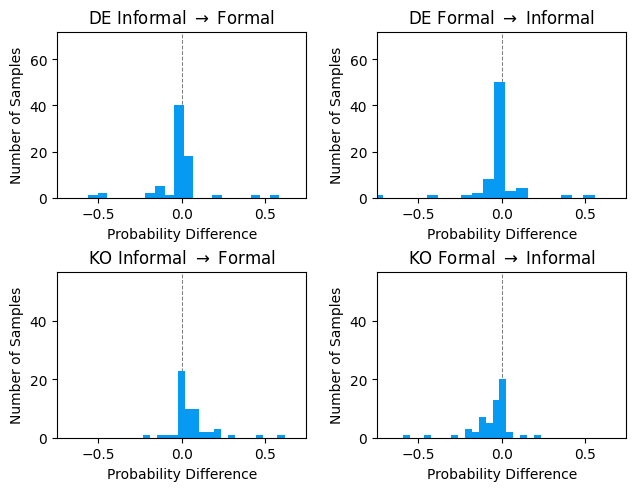

In [27]:
fig, ax = plt.subplots(2, 2, layout="constrained")

for row in range(2):
    for col in range(2):
        list_idx = row * 2 + col
        ax[row, col].axvline(
            x=0, linewidth=0.75, linestyle="dashed", color="grey", zorder=0
        )
        ax[row, col].hist(contrast_probs[list_idx]["data"], bins=20, color="xkcd:azure")
        ax[row, col].set_title(contrast_probs[list_idx]["title"])
        ax[row, col].set_xlabel("Probability Difference")
        ax[row, col].set_ylabel("Number of Samples")
        ax[row, col].set_xlim(-0.75, 0.75)
        ax[row, col].set_ylim(0, len(contrast_probs[list_idx]["data"]))


In [43]:
all_pos_list = attribute.get_max_contr_pos_tags(
    ds_formal_contr_de, model_ko_de, "informal_ko"
)


In [44]:
all_pos_list2 = attribute.get_max_contr_pos_tags(
    ds_informal_contr_de, model_ko_de, "formal_ko"
)


In [45]:
import pandas as pd


In [46]:
max_pos_df = pd.DataFrame({"formal": all_pos_list, "informal": all_pos_list2})


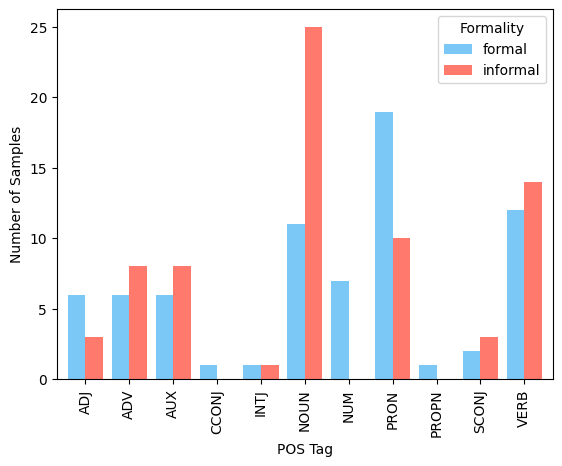

In [47]:
ax = max_pos_df.apply(pd.Series.value_counts).plot(
    kind="bar", color=["xkcd:lightblue", "xkcd:salmon"], width=0.8
)
ax.set_xlabel("POS Tag")
ax.set_ylabel("Number of Samples")
ax.legend(title="Formality")
